# FIFA 2026 Player Rating Insights

##  Project Goal
To evaluate and cluster soccer players based on their performance, potential, and market value, and to identify undervalued world-class talent for FIFA World Cup 2026.

---

##  Methods
1. **Data Cleaning**
   - Handle missing values (GK/outfield split).
   - Normalize numeric values.
   - Standardize text fields.

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "2"
os.environ["MKL_NUM_THREADS"] = "2"
os.environ["NUMEXPR_NUM_THREADS"] = "2"

In [2]:

# 1. Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import silhouette_score

# 2. Load dataset
df = pd.read_csv("FIFA_Players_Stats.csv")# 3. Data audit
#3. Preview dataset
print(df.info())
print(df.describe())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   player_id              320 non-null    int64  
 1   name                   320 non-null    object 
 2   age                    320 non-null    int64  
 3   nationality            320 non-null    object 
 4   club                   320 non-null    object 
 5   position               320 non-null    object 
 6   preferred_foot         320 non-null    object 
 7   height_cm              320 non-null    int64  
 8   weight_kg              320 non-null    int64  
 9   minutes_played_24_25   320 non-null    int64  
 10  goals                  320 non-null    int64  
 11  assists                320 non-null    int64  
 12  shots                  320 non-null    int64  
 13  key_passes             320 non-null    int64  
 14  xG                     320 non-null    float64
 15  xA    

In [3]:
df.head(10)

,player_id,name,age,nationality,club,position,preferred_foot,height_cm,weight_kg,minutes_played_24_25,...,save_pct,yellow_cards,red_cards,contract_years_left,market_value_millions,injury_days_24_25,rating_2023,rating_2024,rating_2025,form_index_last10
0,1,Sandro Silveira,31,Scotland,Tottenham,DEF,Right,186,86,1912,...,NaN,4,0,1,2.76,15,70.6,72.1,73.2,-1.15
1,2,Sandro Lewandov,20,Mexico,Inter,GK,Right,191,83,2631,...,64.8,3,0,1,15.60,7,62.5,65.6,63.6,0.09
2,3,Karim Pulisico,29,Bulgaria,Besiktas,MID,Both,184,74,1558,...,NaN,6,0,0,9.53,12,78.2,75.0,78.1,-2.50
3,4,Karim Sakara,29,Serbia,Manchester City,GK,Right,193,83,2009,...,73.8,1,0,1,16.61,0,62.4,63.0,65.2,-1.25
4,5,Kylian Diazo,17,USA,Flamengo,MID,Both,180,72,1970,...,NaN,1,1,2,5.00,14,75.9,81.1,75.9,0.59
5,6,Marco Nunezi,17,Denmark,Galatasaray,GK,Both,202,83,1142,...,71.1,0,1,1,3.57,55,73.8,75.2,74.4,0.18
6,7,Christian Silveira,35,Poland,Inter,DEF,Left,186,78,2300,...,NaN,2,0,2,17.54,8,70.0,69.3,69.1,-0.08
7,8,Marco De Jongh,18,Argentina,Olympiacos,FWD,Right,185,84,1025,...,NaN,8,1,3,8.75,2,69.9,67.1,68.4,-1.62
8,9,Bukayo Hakimi,19,Chile,Roma,FWD,Right,177,77,2146,...,NaN,6,0,2,11.09,4,67.9,67.8,69.3,2.31
9,10,Joao Lewandov,33,Chile,Chelsea,DEF,Right,171,71,1832,...,NaN,3,0,0,13.50,5,77.5,77.3,78.2,-1.61


In [4]:
# 4. Data cleaning

# --- Handle missing values ---
# For GK-only stats (saves, goals_conceded, save_pct), impute with 0 for outfielders.
df['saves'] = df['saves'].fillna(0)
df['goals_conceded'] = df['goals_conceded'].fillna(0)
df['save_pct'] = df['save_pct'].fillna(0)

# For other numeric columns, fill missing with median by position
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        df[col] = df.groupby("position")[col].transform(lambda x: x.fillna(x.median()))

# --- Standardize text ---
df['nationality'] = df['nationality'].str.strip().str.title()
df['club'] = df['club'].str.strip().str.title()
df['preferred_foot'] = df['preferred_foot'].str.strip().str.capitalize()
df['position'] = df['position'].str.upper()

# --- Remove impossible values ---
# Minutes cannot be negative
df['minutes_played_24_25'] = df['minutes_played_24_25'].clip(lower=0)

# Height and weight reasonable bounds
df['height_cm'] = df['height_cm'].clip(lower=150, upper=210)
df['weight_kg'] = df['weight_kg'].clip(lower=50, upper=110)

# Ratings (55–99 realistic FIFA scale)
for col in ['rating_2023', 'rating_2024', 'rating_2025']:
    df[col] = df[col].clip(lower=55, upper=99)

# Market value must be non-negative
df['market_value_millions'] = df['market_value_millions'].clip(lower=0)

df.head()

,player_id,name,age,nationality,club,position,preferred_foot,height_cm,weight_kg,minutes_played_24_25,...,save_pct,yellow_cards,red_cards,contract_years_left,market_value_millions,injury_days_24_25,rating_2023,rating_2024,rating_2025,form_index_last10
0,1,Sandro Silveira,31,Scotland,Tottenham,DEF,Right,186,86,1912,...,0.0,4,0,1,2.76,15,70.6,72.1,73.2,-1.15
1,2,Sandro Lewandov,20,Mexico,Inter,GK,Right,191,83,2631,...,64.8,3,0,1,15.60,7,62.5,65.6,63.6,0.09
2,3,Karim Pulisico,29,Bulgaria,Besiktas,MID,Both,184,74,1558,...,0.0,6,0,0,9.53,12,78.2,75.0,78.1,-2.50
3,4,Karim Sakara,29,Serbia,Manchester City,GK,Right,193,83,2009,...,73.8,1,0,1,16.61,0,62.4,63.0,65.2,-1.25
4,5,Kylian Diazo,17,Usa,Flamengo,MID,Both,180,72,1970,...,0.0,1,1,2,5.00,14,75.9,81.1,75.9,0.59


## 2. **Feature Engineering**
   - Per-90 stats.
   - Position-specific indices (FinishingIndex, CreatorIndex, StopperIndex, ShotStopIndex).
   - Composite `PerformanceScore`.
   - Trajectory features (rating deltas, form index).



In [5]:
# ===================================================
# 5) Feature Engineering (rewritten with dtype fixes)
# ===================================================

import numpy as np
import pandas as pd

# ---------- Helpers ----------
def per90(series, minutes):
    """Safe per-90: returns 0 when minutes == 0 or NaN."""
    m = minutes.replace(0, np.nan)
    out = series / (m / 90.0)
    return out.replace([np.inf, -np.inf], np.nan).fillna(0)

def scale_0_100(s: pd.Series) -> pd.Series:
    """Min-max scale to 0–100 (handles constant series & NaNs)."""
    s = pd.to_numeric(s, errors="coerce")
    lo, hi = s.min(skipna=True), s.max(skipna=True)
    if pd.isna(lo) or pd.isna(hi) or hi == lo:
        return pd.Series(np.zeros(len(s), dtype=float), index=s.index)
    return ((s - lo) * 100.0 / (hi - lo)).astype(float)

# ---------- Per-90 core stats ----------
mp = df["minutes_played_24_25"]
df["goals_per90"]         = per90(df["goals"],              mp)
df["assists_per90"]       = per90(df["assists"],            mp)
df["shots_per90"]         = per90(df["shots"],              mp)
df["key_passes_per90"]    = per90(df["key_passes"],         mp)
df["dribbles_per90"]      = per90(df["dribbles_completed"], mp)
df["tackles_per90"]       = per90(df["tackles"],            mp)
df["interceptions_per90"] = per90(df["interceptions"],      mp)
df["clearances_per90"]    = per90(df["clearances"],         mp)
df["aerials_won_per90"]   = per90(df["aerials_won"],        mp)
df["saves_per90"]         = per90(df["saves"],              mp)

# ---------- Trajectory & form ----------
df["rating_delta_24_23"] = df["rating_2024"] - df["rating_2023"]
df["rating_delta_25_24"] = df["rating_2025"] - df["rating_2024"]
df["rating_trend_23_25"] = df["rating_2025"] - df["rating_2023"]
df["form_score"] = scale_0_100(df["form_index_last10"])

# ---------- Position-aware raw indices ----------
finishing_raw = (
    0.50 * df["goals_per90"] +
    0.30 * df["shots_per90"] +
    0.20 * df["xG"].fillna(0)
)

creator_raw = (
    0.45 * df["key_passes_per90"] +
    0.35 * df["xA"].fillna(0) +
    0.20 * df["pass_accuracy_pct"]
)

stopper_raw = (
    0.40 * df["tackles_per90"] +
    0.40 * df["interceptions_per90"] +
    0.20 * df["aerials_won_per90"]
)

shotstop_raw = (
    0.60 * df["save_pct"] +
    0.40 * df["saves_per90"]
)

# ---------- Initialize index columns as float (prevents dtype warning) ----------
df["FinishingIndex"] = 0.0
df["CreatorIndex"]   = 0.0
df["StopperIndex"]   = 0.0
df["ShotStopIndex"]  = 0.0

# ---------- Scale each index within position ----------
for pos, raw, outcol in [
    ("FWD", finishing_raw, "FinishingIndex"),
    ("MID", creator_raw,   "CreatorIndex"),
    ("DEF", stopper_raw,   "StopperIndex"),
    ("GK",  shotstop_raw,  "ShotStopIndex"),
]:
    mask = df["position"].eq(pos)
    df.loc[mask, outcol] = scale_0_100(raw[mask]).astype(float)

# Ensure non-applicable indices are 0.0
for c in ["FinishingIndex","CreatorIndex","StopperIndex","ShotStopIndex"]:
    df[c] = df[c].fillna(0.0).astype(float)

# ---------- Composite PerformanceScore ----------
fin_norm   = scale_0_100(df["FinishingIndex"])
cre_norm   = scale_0_100(df["CreatorIndex"])
stp_norm   = scale_0_100(df["StopperIndex"])
gk_norm    = scale_0_100(df["ShotStopIndex"])
trend_norm = scale_0_100(df["rating_trend_23_25"])
form_norm  = df["form_score"]  # already 0–100

df["PerformanceScore"] = np.where(
    df["position"].eq("FWD"),
    0.55*fin_norm + 0.20*cre_norm + 0.10*trend_norm + 0.15*form_norm,
    np.where(
        df["position"].eq("MID"),
        0.50*cre_norm + 0.15*fin_norm + 0.15*stp_norm + 0.10*trend_norm + 0.10*form_norm,
        np.where(
            df["position"].eq("DEF"),
            0.55*stp_norm + 0.10*cre_norm + 0.10*fin_norm + 0.10*trend_norm + 0.15*form_norm,
            # GK
            0.65*gk_norm + 0.15*trend_norm + 0.20*form_norm
        )
    )
).astype(float)

# Final scaling for readability
df["PerformanceScore"] = scale_0_100(df["PerformanceScore"]).astype(float)

# ---------- Value & risk features ----------
with np.errstate(divide="ignore", invalid="ignore"):
    df["value_per90"] = (
        df["market_value_millions"] / (df["minutes_played_24_25"].replace(0, np.nan) / 90.0)
    )
df["value_per90"] = df["value_per90"].replace([np.inf, -np.inf], np.nan).fillna(0.0).astype(float)

denom = df["PerformanceScore"].replace(0, np.nan)
df["value_per_point"] = (df["market_value_millions"] / denom).replace([np.inf, -np.inf], np.nan)
df["value_per_point"] = df["value_per_point"].fillna(df["market_value_millions"]).astype(float)

df["injury_risk_flag"] = (df["injury_days_24_25"] > df["injury_days_24_25"].median()).astype(int)

# ---------- Age curve features ----------
df["age_sq"]         = (df["age"]**2).astype(float)
df["age_x_pos_DEF"]  = ((df["position"]=="DEF").astype(int) * df["age"]).astype(float)
df["age_x_pos_MID"]  = ((df["position"]=="MID").astype(int) * df["age"]).astype(float)
df["age_x_pos_FWD"]  = ((df["position"]=="FWD").astype(int) * df["age"]).astype(float)
df["age_x_pos_GK"]   = ((df["position"]=="GK").astype(int)  * df["age"]).astype(float)

print("✅ Feature engineering complete.")
new_cols = [
    "goals_per90","assists_per90","shots_per90","key_passes_per90","dribbles_per90",
    "tackles_per90","interceptions_per90","clearances_per90","aerials_won_per90","saves_per90",
    "rating_delta_24_23","rating_delta_25_24","rating_trend_23_25","form_score",
    "FinishingIndex","CreatorIndex","StopperIndex","ShotStopIndex","PerformanceScore",
    "value_per90","value_per_point","injury_risk_flag",
    "age_sq","age_x_pos_DEF","age_x_pos_MID","age_x_pos_FWD","age_x_pos_GK"
]
print("New columns added:", new_cols)
df.head()

✅ Feature engineering complete.
New columns added: ['goals_per90', 'assists_per90', 'shots_per90', 'key_passes_per90', 'dribbles_per90', 'tackles_per90', 'interceptions_per90', 'clearances_per90', 'aerials_won_per90', 'saves_per90', 'rating_delta_24_23', 'rating_delta_25_24', 'rating_trend_23_25', 'form_score', 'FinishingIndex', 'CreatorIndex', 'StopperIndex', 'ShotStopIndex', 'PerformanceScore', 'value_per90', 'value_per_point', 'injury_risk_flag', 'age_sq', 'age_x_pos_DEF', 'age_x_pos_MID', 'age_x_pos_FWD', 'age_x_pos_GK']


,player_id,name,age,nationality,club,position,preferred_foot,height_cm,weight_kg,minutes_played_24_25,...,ShotStopIndex,PerformanceScore,value_per90,value_per_point,injury_risk_flag,age_sq,age_x_pos_DEF,age_x_pos_MID,age_x_pos_FWD,age_x_pos_GK
0,1,Sandro Silveira,31,Scotland,Tottenham,DEF,Right,186,86,1912,...,0.000000,7.607363,0.129916,0.362806,1,961.0,31.0,0.0,0.0,0.0
1,2,Sandro Lewandov,20,Mexico,Inter,GK,Right,191,83,2631,...,17.315576,31.112824,0.533637,0.501401,0,400.0,0.0,0.0,0.0,20.0
2,3,Karim Pulisico,29,Bulgaria,Besiktas,MID,Both,184,74,1558,...,0.000000,27.394083,0.550513,0.347885,1,841.0,0.0,29.0,0.0,0.0
3,4,Karim Sakara,29,Serbia,Manchester City,GK,Right,193,83,2009,...,68.136240,66.361038,0.744102,0.250297,0,841.0,0.0,0.0,0.0,29.0
4,5,Kylian Diazo,17,Usa,Flamengo,MID,Both,180,72,1970,...,0.000000,36.263167,0.228426,0.137881,1,289.0,0.0,17.0,0.0,0.0


## 3. Exploratory Data Analysis (EDA)

Inspect distributions (age, PerformanceScore).

Compare PerformanceScore by position; print Top-5 per position.

Explore value vs. performance to spot undervalued players.

Correlation heatmap of engineered features to detect redundancy.

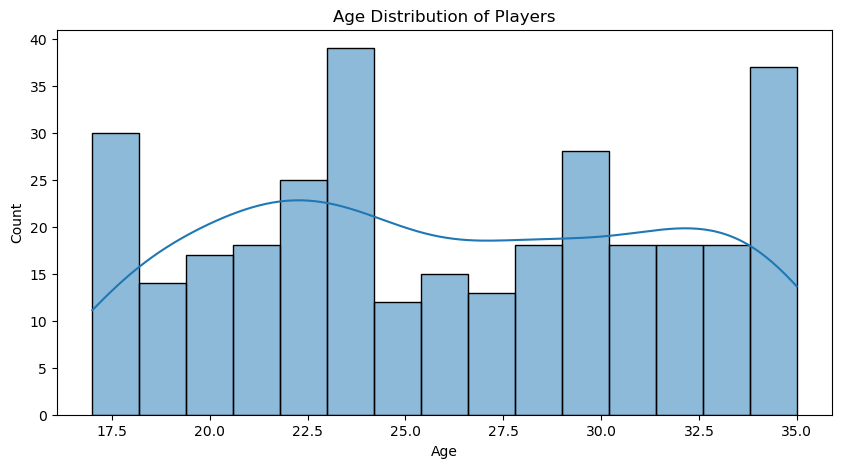

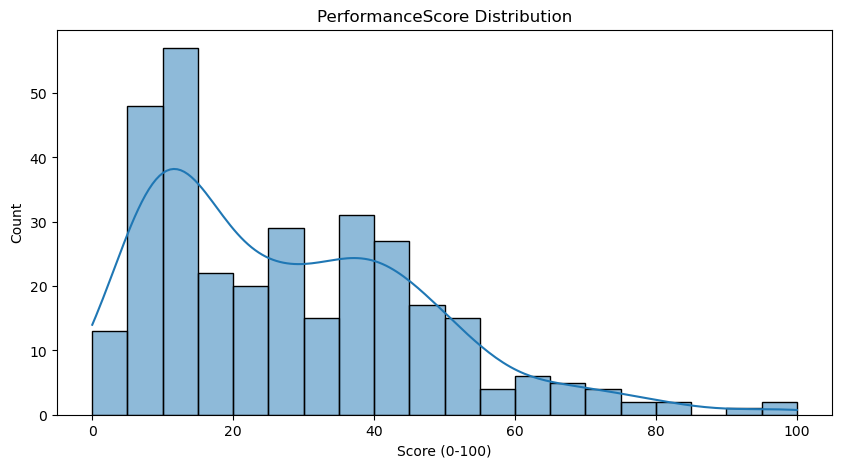

Average PerformanceScore by position:
 position
GK     60.420607
MID    33.619870
FWD    31.736387
DEF    10.237527
Name: PerformanceScore, dtype: float64


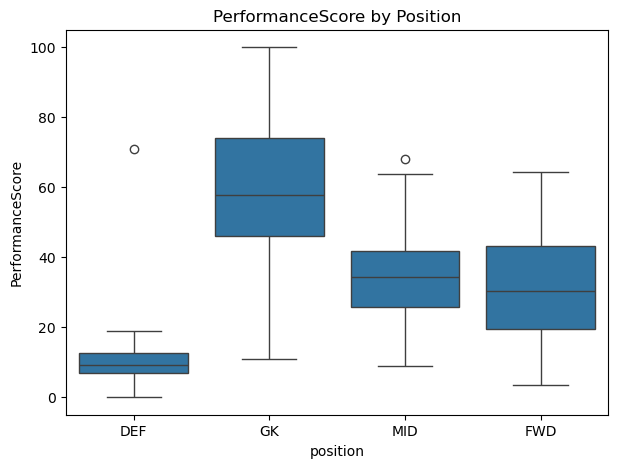


Top 5 DEF by PerformanceScore:
                 name  age       club   nationality  PerformanceScore  \
106  Yassine Silveira   22       Roma         Chile         70.886986   
245     Pedri Junioro   28   Atalanta   South Korea         19.048461   
65    Harry Fernandis   35   Juventus  Saudi Arabia         18.902585   
22     Erling Oshimen   30  Liverpool         Ghana         18.509898   
309    Jonathan Maney   33      Porto      Bulgaria         17.803808   

     market_value_millions  
106                  22.63  
245                   3.02  
65                   15.60  
22                   18.28  
309                  40.17  

Top 5 GK by PerformanceScore:
               name  age           club  nationality  PerformanceScore  \
79    Victor Hakimi   26       Valencia      Ireland        100.000000   
143   Marcus Felixo   34  Bayern Munich        Spain         97.675266   
183  Bernardo Diazo   23    Tigres Uanl  South Korea         90.718207   
141    Dusan Chiesi   23    

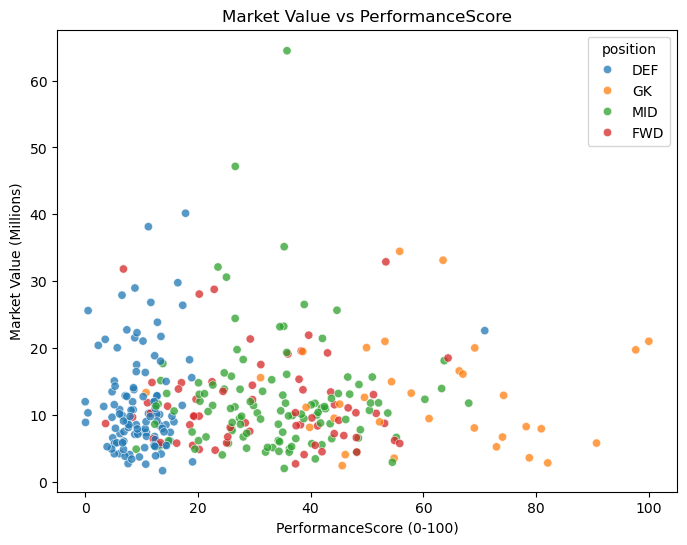

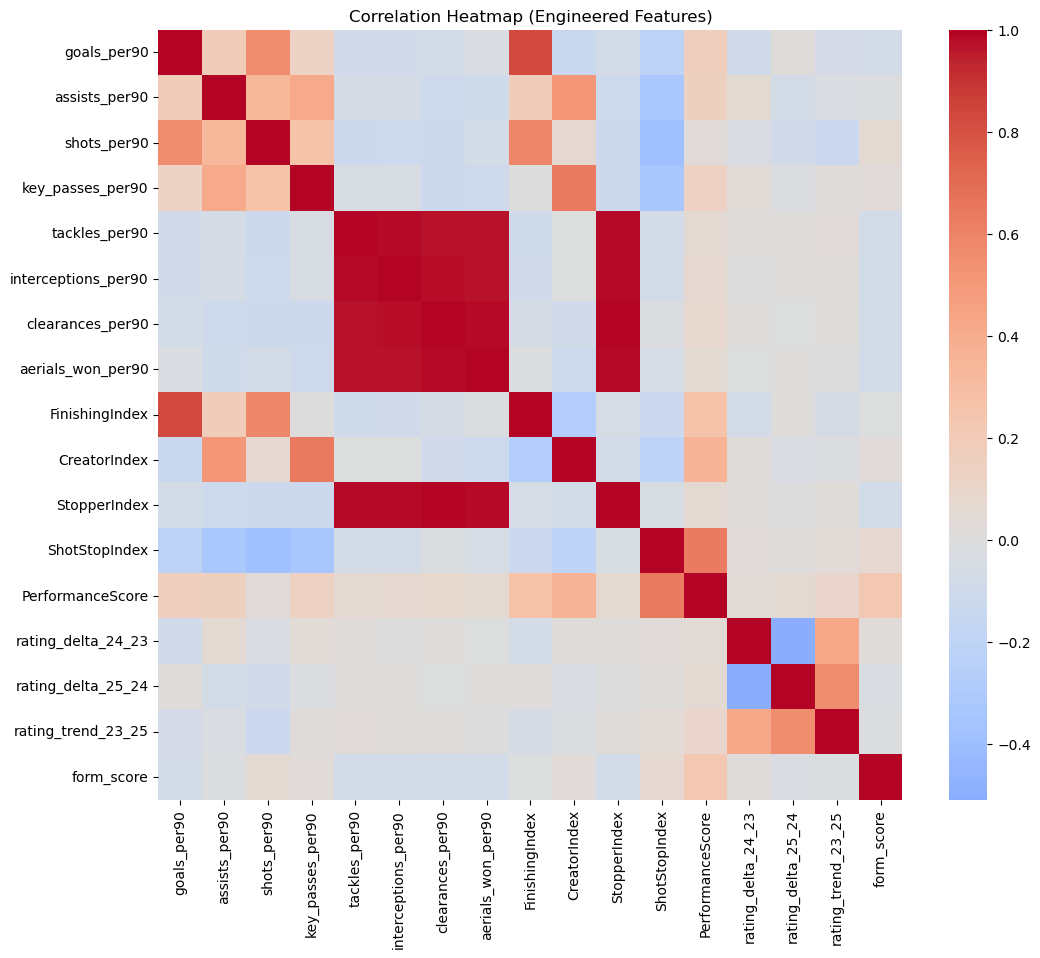

In [6]:

#  Distributions
plt.figure(figsize=(10,5))
sns.histplot(df["age"], bins=15, kde=True)
plt.title("Age Distribution of Players"); plt.xlabel("Age"); plt.ylabel("Count")
plt.show()

plt.figure(figsize=(10,5))
sns.histplot(df["PerformanceScore"], bins=20, kde=True)
plt.title("PerformanceScore Distribution"); plt.xlabel("Score (0-100)"); plt.ylabel("Count")
plt.show()

#  Position-wise PerformanceScore
pos_avg = df.groupby("position")["PerformanceScore"].mean().sort_values(ascending=False)
print("Average PerformanceScore by position:\n", pos_avg)

plt.figure(figsize=(7,5))
sns.boxplot(data=df, x="position", y="PerformanceScore")
plt.title("PerformanceScore by Position")
plt.show()

#  Top-5 per position
for pos in df["position"].unique():
    top5 = (df.loc[df["position"]==pos]
              .sort_values("PerformanceScore", ascending=False)
              .head(5))
    print(f"\nTop 5 {pos} by PerformanceScore:")
    print(top5[["name","age","club","nationality","PerformanceScore","market_value_millions"]])

#  Market value vs Performance
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="PerformanceScore", y="market_value_millions", hue="position", alpha=0.75)
plt.title("Market Value vs PerformanceScore")
plt.xlabel("PerformanceScore (0-100)"); plt.ylabel("Market Value (Millions)")
plt.show()

#  Correlation heatmap (engineered features)
feat_cols = [
    "goals_per90","assists_per90","shots_per90","key_passes_per90",
    "tackles_per90","interceptions_per90","clearances_per90","aerials_won_per90",
    "FinishingIndex","CreatorIndex","StopperIndex","ShotStopIndex","PerformanceScore",
    "rating_delta_24_23","rating_delta_25_24","rating_trend_23_25","form_score"
]
corr = df[feat_cols].corr(numeric_only=True)
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Engineered Features)")
plt.show()


## 4. Unsupervised Learning — Player Archetypes
## Objective

Group players into archetypes (styles of play) so analysts, scouts, and coaches can quickly understand what type of player they are dealing with.

## Process

Standardize features – scale all chosen metrics (per-90, indices, PerformanceScore, etc.) to be comparable.

Reduce dimensionality with PCA – compress the data into a smaller set of components that still explain ~90% of the variance. This makes clusters more stable and visualizations possible.

Cluster with K-Means – find natural groups of players.

Label & interpret clusters – give human-readable names (e.g., Poacher, Creator, Stopper, Shot-Stop GK).

Visualize in PCA space – 2D scatterplot colored by archetype.

## Deliverables

A new column in the dataset: cluster_name.

A cluster profile table summarizing feature means per group.

A 2D PCA scatter plot showing player archetypes

PCA reduced features → 6 components (variance explained = 0.90)
Chosen K = 4 | silhouette = 0.368


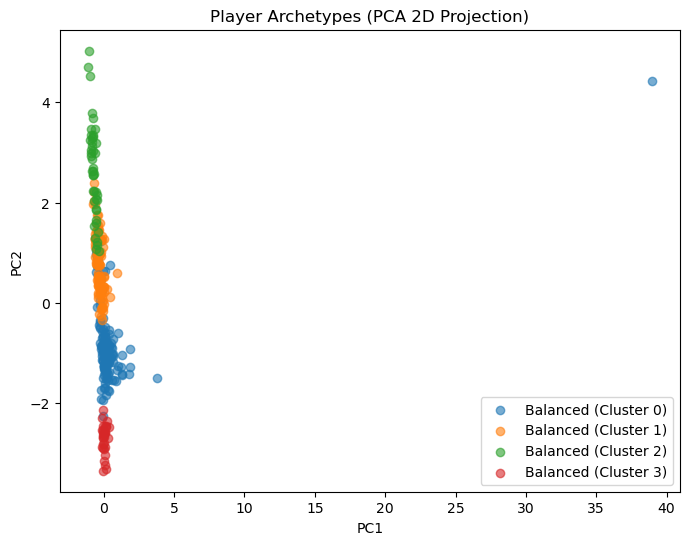


Cluster profiles with names:

         goals_per90  assists_per90  shots_per90  key_passes_per90  \
cluster                                                              
0               0.06           0.07         0.75              0.61   
1               0.10           0.22         1.12              1.69   
2               0.51           0.18         2.18              1.04   
3               0.00           0.01         0.00              0.22   

         tackles_per90  interceptions_per90  clearances_per90  \
cluster                                                         
0                 2.12                 2.11              4.89   
1                 1.59                 1.57              0.82   
2                 0.46                 0.34              0.68   
3                 0.33                 0.23              1.97   

         aerials_won_per90  FinishingIndex  CreatorIndex  StopperIndex  \
cluster                                                                  
0        

In [7]:
# ===================================================
# Step 4: Unsupervised Learning (Player Archetypes)
# ===================================================


# 1) Select engineered features
cluster_features = [
    "goals_per90","assists_per90","shots_per90","key_passes_per90",
    "tackles_per90","interceptions_per90","clearances_per90","aerials_won_per90",
    "FinishingIndex","CreatorIndex","StopperIndex","ShotStopIndex",
    "PerformanceScore","rating_trend_23_25","form_score"
]
X = df[cluster_features].fillna(0.0).astype(float)

# 2) Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3) PCA (retain ~90% variance)
pca = PCA(n_components=0.90, svd_solver="full")
X_pca = pca.fit_transform(X_scaled)
print(f"PCA reduced features → {X_pca.shape[1]} components (variance explained = {pca.explained_variance_ratio_.sum():.2f})")

# 4) KMeans clustering (choose K with silhouette score)
sil = {}
for k in range(3, 9):
    km = KMeans(n_clusters=k, n_init="auto", random_state=42)
    labels = km.fit_predict(X_pca)
    sil[k] = silhouette_score(X_pca, labels)

best_k = max(sil, key=sil.get)
print("Chosen K =", best_k, "| silhouette =", round(sil[best_k], 3))

kmeans = KMeans(n_clusters=best_k, n_init="auto", random_state=42)
df["cluster"] = kmeans.fit_predict(X_pca)

# 5) Interpret clusters: average stats per cluster
cluster_profile = df.groupby("cluster")[cluster_features].mean().round(2)

def name_cluster(row):
    if row["FinishingIndex"] > 70 and row["shots_per90"] > 2.0:
        return "Poacher"
    if row["CreatorIndex"] > 70 and row["key_passes_per90"] > 1.5:
        return "Playmaker"
    if row["StopperIndex"] > 70 and row["tackles_per90"] > 1.5:
        return "Defensive Rock"
    if row["ShotStopIndex"] > 70:
        return "Shot-Stop GK"
    return "Balanced"

cluster_names = cluster_profile.apply(name_cluster, axis=1).to_dict()
df["cluster_name"] = df["cluster"].map(cluster_names)

# 6) Visualize clusters in PCA space
plt.figure(figsize=(8,6))
for c in sorted(df["cluster"].unique()):
    mask = df["cluster"]==c
    plt.scatter(X_pca[mask,0], X_pca[mask,1], alpha=0.6, label=f'{cluster_names[c]} (Cluster {c})')
plt.title("Player Archetypes (PCA 2D Projection)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend()
plt.show()

# 7) Show summary
print("\nCluster profiles with names:\n")
print(cluster_profile.assign(archetype=cluster_profile.apply(name_cluster, axis=1)))

